# Question 1: Which states are most similar in terms of their national park type distribution?

We can create vectors for each state based on the type and quantity of national parks they have (National Historic Monument, National Lakeshore, etc). We can create a network of the states by calculating pairwise similarity of the vectors, where each node is a state/region and the edges are weighted by similarity. Then we complete a network analysis of the state nodes to find the state with highest between-
ness, closeness centrality, etc.

In [142]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import itertools
import scipy
from dtaidistance import dtw
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



To start, let's read in the time series data.

In [3]:
visit_data = pd.read_csv('timeseries_data.csv',index_col='Unnamed: 0')
visit_data['date'] = pd.to_datetime(visit_data['date'], infer_datetime_format=True)
print('The shape is: ',visit_data.shape)
print('The columns are: ',visit_data.columns)
print('The visit types are: ',visit_data['visit_type'].unique())

The shape is:  (1026608, 8)
The columns are:  Index(['ParkName', 'UnitCode', 'ParkType', 'Region', 'state_2', 'date',
       'visit_type', 'number_of_visits'],
      dtype='object')
The visit types are:  ['RecreationVisits' 'NonRecreationVisits' 'RecreationHours'
 'NonRecreationHours' 'ConcessionerLodging' 'ConcessionerCamping'
 'TentCampers' 'RVCampers' 'Backcountry' 'NonRecreationOvernightStays'
 'MiscellaneousOvernightStays']


In [342]:
palette = ['#56903A','#C56C39','#BAE5F9','#6F4930','#213A1B','#FF784F','#3A3042']
sns.set_palette(palette)

Let's start by looking at a few of the most popular parks.

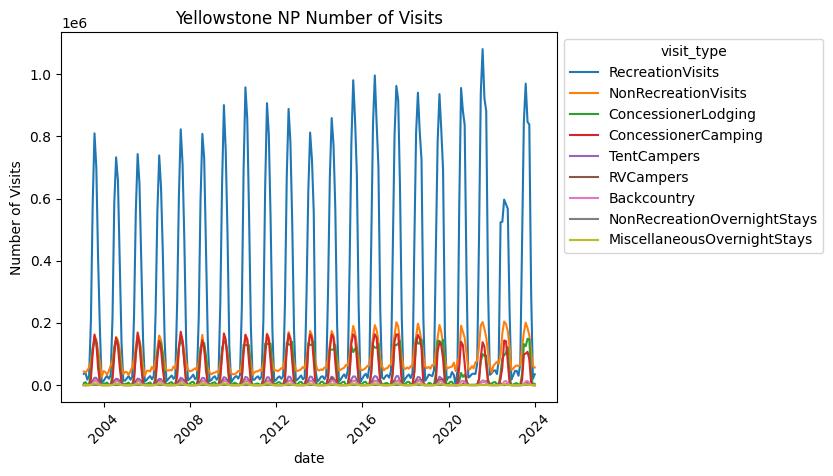

In [4]:
yellowstone_only = visit_data[visit_data.ParkName.str.contains('Yellowstone')]
# don't want to look at hours, want to do only visits
yellowstone_only = yellowstone_only[yellowstone_only.visit_type.isin(['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'])]
ax = sns.lineplot(yellowstone_only,x='date',y='number_of_visits',hue='visit_type')
plt.title('Yellowstone NP Number of Visits')
plt.ylabel('Number of Visits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = plt.tick_params(axis='x',rotation=45)

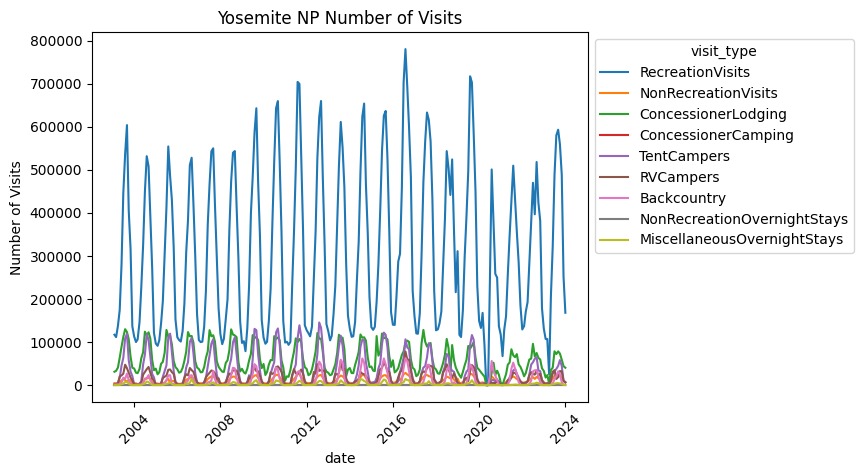

In [5]:
yellowstone_only = visit_data[visit_data.ParkName.str.contains('Yosemite')]
# don't want to look at hours, want to do only visits
yellowstone_only = yellowstone_only[yellowstone_only.visit_type.isin(['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'])]
ax = sns.lineplot(yellowstone_only,x='date',y='number_of_visits',hue='visit_type')
plt.title('Yosemite NP Number of Visits')
plt.ylabel('Number of Visits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = plt.tick_params(axis='x',rotation=45)

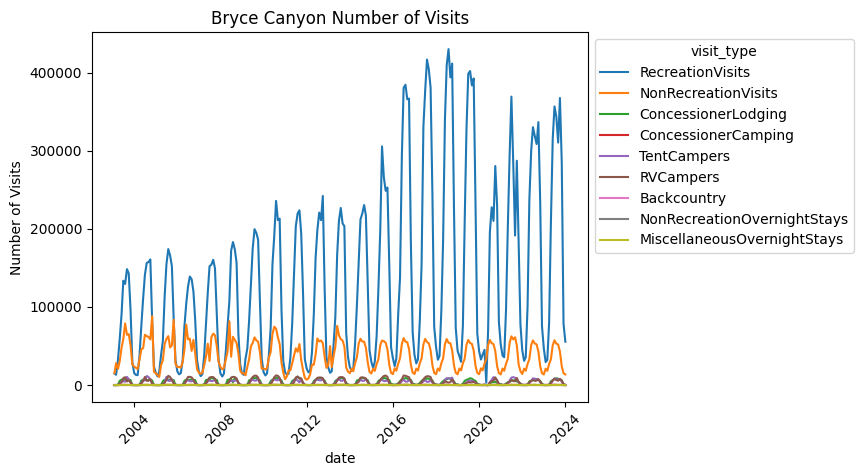

In [6]:
yellowstone_only = visit_data[visit_data.ParkName.str.contains('Bryce')]
# don't want to look at hours, want to do only visits
yellowstone_only = yellowstone_only[yellowstone_only.visit_type.isin(['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'])]
ax = sns.lineplot(yellowstone_only,x='date',y='number_of_visits',hue='visit_type')
plt.title('Bryce Canyon Number of Visits')
plt.ylabel('Number of Visits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = plt.tick_params(axis='x',rotation=45)

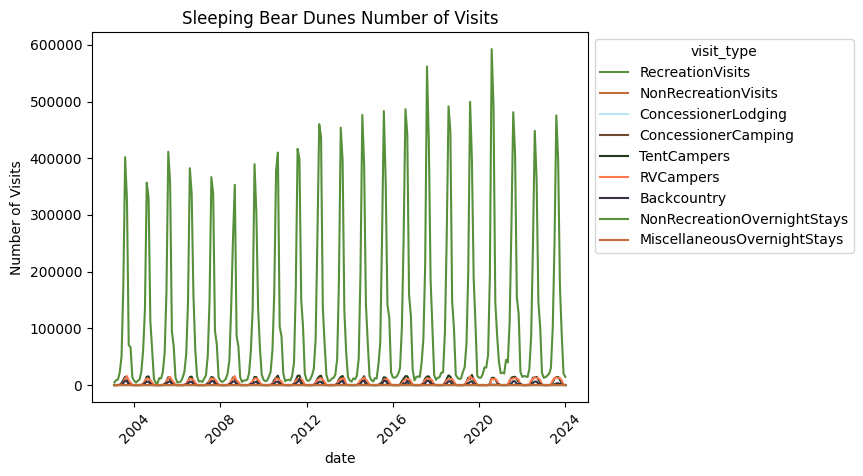

In [343]:
yellowstone_only = visit_data[visit_data.ParkName.str.contains('Sleeping Bear')]
# don't want to look at hours, want to do only visits
yellowstone_only = yellowstone_only[yellowstone_only.visit_type.isin(['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'])]
ax = sns.lineplot(yellowstone_only,x='date',y='number_of_visits',hue='visit_type',palette=palette)
plt.title('Sleeping Bear Dunes Number of Visits')
plt.ylabel('Number of Visits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
_ = plt.tick_params(axis='x',rotation=45)

We can already start to see the different seasonal patterns that are emerging. Now let's look at a few states.

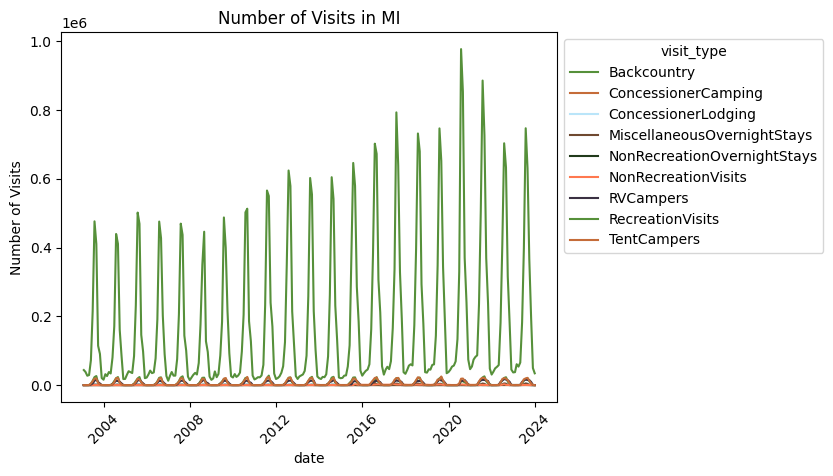

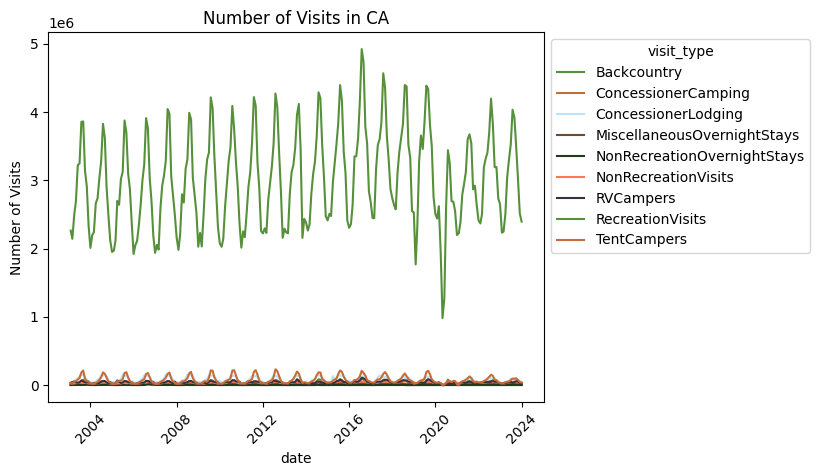

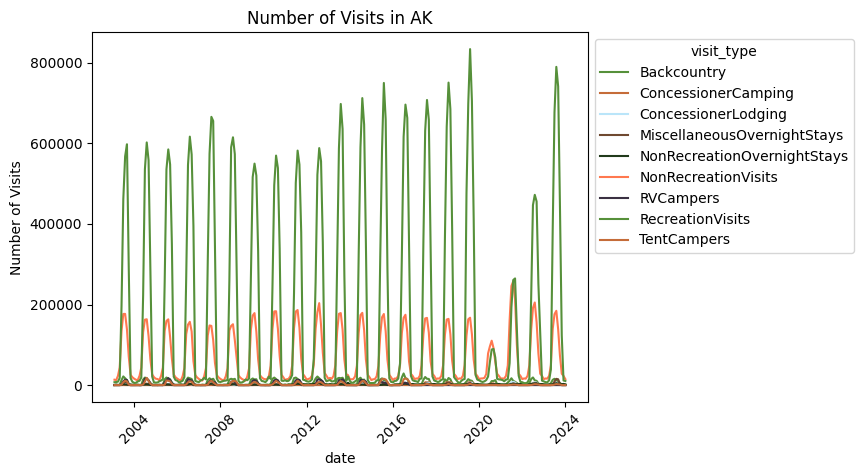

In [345]:
# picking my favorite states
states = ['MI','CA','AK']
for st in states:
    state_only = visit_data[visit_data.state_2 == st]
    cols = ['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
        'TentCampers', 'RVCampers', 'Backcountry',
        'NonRecreationOvernightStays', 'MiscellaneousOvernightStays']
    # don't want to look at hours, want to do only visits
    state_only = state_only[state_only.visit_type.isin(cols)]
    #group across all parks
    state_only = state_only.groupby(['state_2','date','visit_type']).sum()['number_of_visits'].reset_index()
    ax = sns.lineplot(state_only,x='date',y='number_of_visits',hue='visit_type',palette=palette)
    plt.title(f'Number of Visits in {st}')
    plt.ylabel('Number of Visits')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    _ = plt.tick_params(axis='x',rotation=45)
    plt.show()

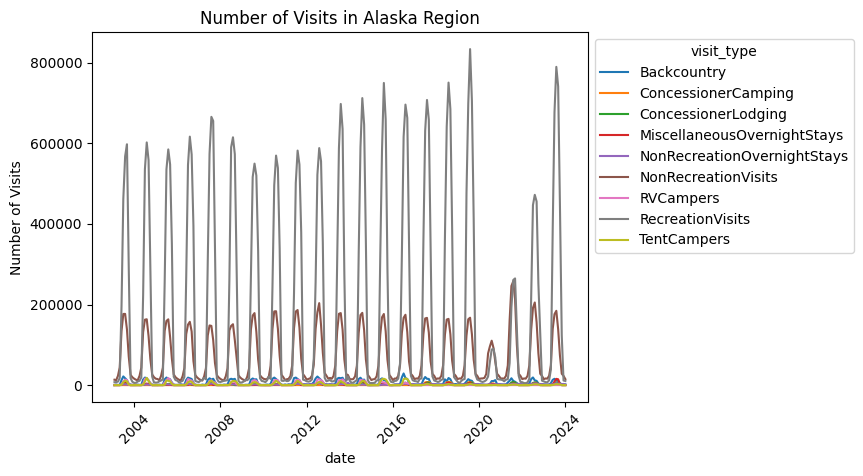

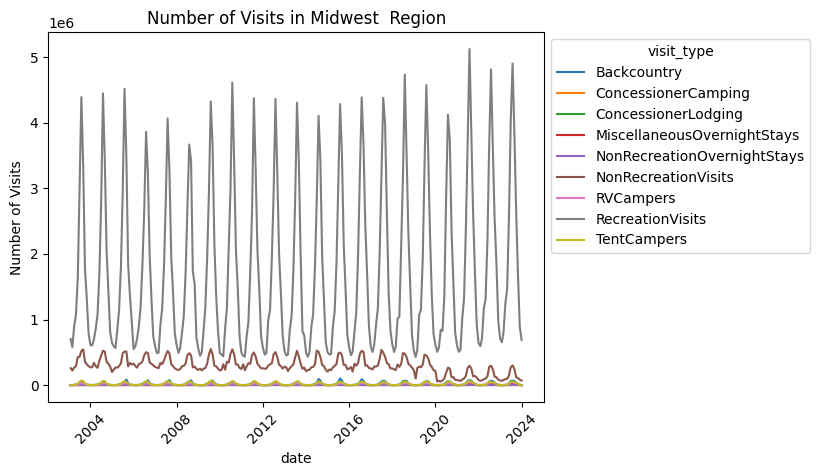

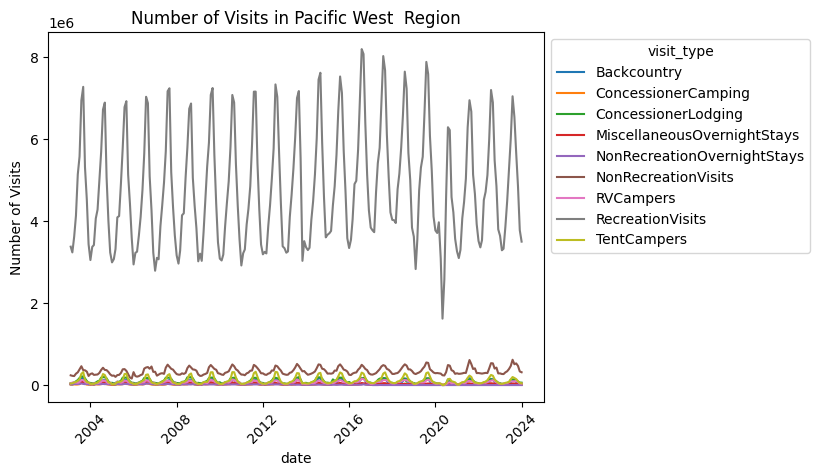

In [9]:
# picking my favorite regions
states = ['Alaska', 'Midwest ','Pacific West ']
for st in states:
    state_only = visit_data[visit_data.Region == st]
    cols = ['RecreationVisits', 'NonRecreationVisits', 'ConcessionerLodging', 'ConcessionerCamping',
        'TentCampers', 'RVCampers', 'Backcountry',
        'NonRecreationOvernightStays', 'MiscellaneousOvernightStays']
    # don't want to look at hours, want to do only visits
    state_only = state_only[state_only.visit_type.isin(cols)]
    #group across all parks
    state_only = state_only.groupby(['Region','date','visit_type']).sum()['number_of_visits'].reset_index()
    ax = sns.lineplot(state_only,x='date',y='number_of_visits',hue='visit_type')
    plt.title(f'Number of Visits in {st} Region')
    plt.ylabel('Number of Visits')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    _ = plt.tick_params(axis='x',rotation=45)
    plt.show()

It's interesting to see off the bat that the number of visits in the Midwest increase during/after covid, but decrease in the Pacific West & Alaska regions during that time. My guess is that Alaska & the Pacific are tourist destinations: people fly to Alaska to visit National Parks. Meanwhile, in Michigan, Ohio, and Indiana people are doing quick domestic trips instead of exciting long trips.

# Trying Differencing
First order: the monthly change in visitors

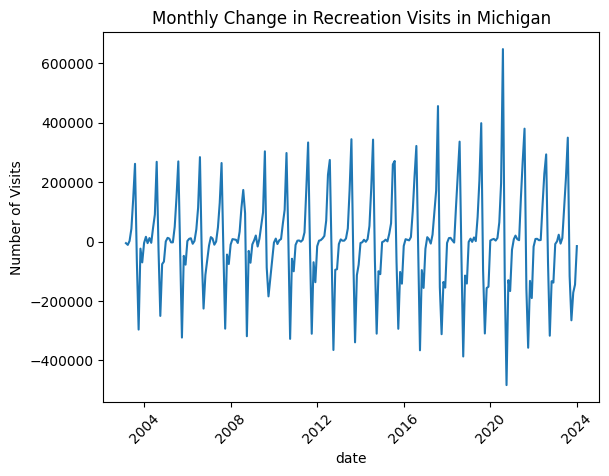

In [10]:
mi=visit_data[visit_data.state_2=='MI'].groupby(['date','visit_type']).sum()['number_of_visits'].reset_index()
# print(mi.head())
mi_diff = mi.pivot(index='date',columns='visit_type',values='number_of_visits').diff().reset_index()
ax = sns.lineplot(mi_diff,x='date',y='RecreationVisits')
plt.title(f'Monthly Change in Recreation Visits in Michigan')
plt.ylabel('Number of Visits')
_ = plt.tick_params(axis='x',rotation=45)

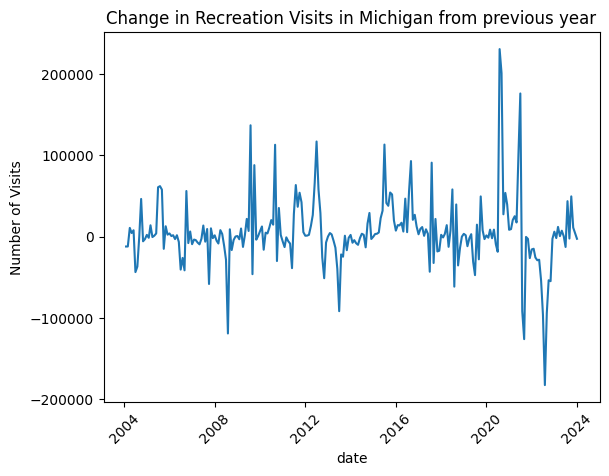

visit_type,date,RecreationVisits
210,2020-07-31,230641.0
211,2020-08-31,201118.0
221,2021-06-30,176088.0
78,2009-07-31,136971.0
113,2012-06-30,117044.0
...,...,...
7,2003-08-31,NaN
8,2003-09-30,NaN
9,2003-10-31,NaN
10,2003-11-30,NaN


In [11]:
mi_y=visit_data[visit_data.state_2=='MI'].groupby(['date','visit_type'])['number_of_visits'].sum().reset_index()
mi_diff = mi_y.pivot(index='date',columns='visit_type',values='number_of_visits').diff(periods=12).reset_index()
ax = sns.lineplot(mi_diff,x='date',y='RecreationVisits')
plt.title(f'Change in Recreation Visits in Michigan from previous year')
plt.ylabel('Number of Visits')
_ = plt.tick_params(axis='x',rotation=45)
plt.show()
mi_diff[['date','RecreationVisits']].sort_values('RecreationVisits',ascending=False)

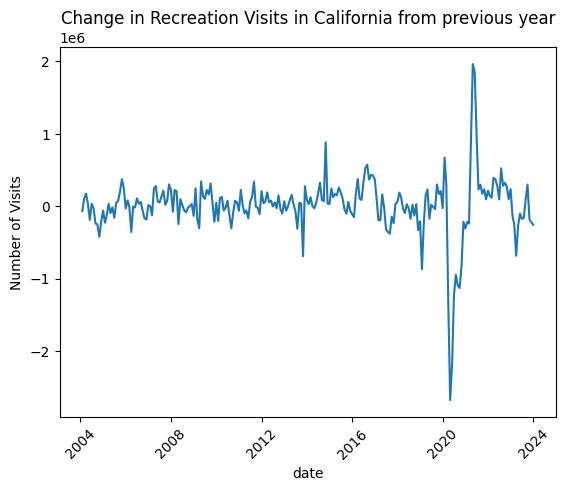

visit_type,date,RecreationVisits
219,2021-04-30,1962968.0
220,2021-05-31,1853192.0
221,2021-06-30,982392.0
141,2014-10-31,881639.0
218,2021-03-31,867758.0
...,...,...
7,2003-08-31,NaN
8,2003-09-30,NaN
9,2003-10-31,NaN
10,2003-11-30,NaN


In [12]:
mi_y=visit_data[visit_data.state_2=='CA'].groupby(['date','visit_type'])['number_of_visits'].sum().reset_index()
mi_diff = mi_y.pivot(index='date',columns='visit_type',values='number_of_visits').diff(periods=12).reset_index()
ax = sns.lineplot(mi_diff,x='date',y='RecreationVisits')
plt.title(f'Change in Recreation Visits in California from previous year')
plt.ylabel('Number of Visits')
_ = plt.tick_params(axis='x',rotation=45)
plt.show()
mi_diff[['date','RecreationVisits']].sort_values('RecreationVisits',ascending=False)

I am interested in trying standardization and seeing if this changes anything interesting.

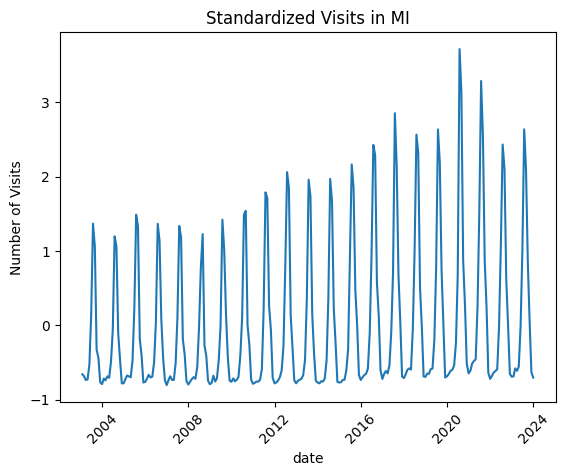

In [13]:
mi_y=visit_data[visit_data.state_2=='MI'].groupby(['date','visit_type'])['number_of_visits'].sum().reset_index()
mi_y=mi_y[mi_y.visit_type =='RecreationVisits']
mi_y['standard_visits']=mi_y['number_of_visits'].apply(lambda z: (z-mi_y['number_of_visits'].mean())/mi_y['number_of_visits'].std())

ax = sns.lineplot(mi_y,x='date',y='standard_visits')
plt.title(f'Standardized Visits in MI')
plt.ylabel('Number of Visits')
_ = plt.tick_params(axis='x',rotation=45)
plt.show()

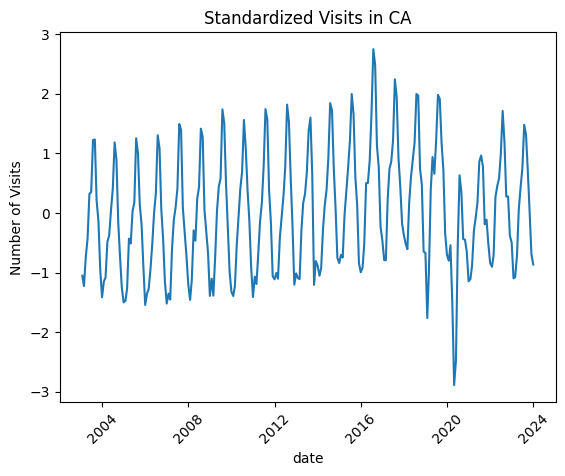

In [14]:
mi_y=visit_data[visit_data.state_2=='CA'].groupby(['date','visit_type'])['number_of_visits'].sum().reset_index()
mi_y=mi_y[mi_y.visit_type =='RecreationVisits']
mi_y['standard_visits']=mi_y['number_of_visits'].apply(lambda z: (z-mi_y['number_of_visits'].mean())/mi_y['number_of_visits'].std())

ax = sns.lineplot(mi_y,x='date',y='standard_visits')
plt.title(f'Standardized Visits in CA')
plt.ylabel('Number of Visits')
_ = plt.tick_params(axis='x',rotation=45)
plt.show()

I think standardized visits might be the best strategy to use, as I am interested in seeing how similar the change in visitation rates are across parks instead of which parks have the most similar visit numbers (raw).

In [146]:
similarities = {}
for type in visit_data.visit_type.unique():
    print(type)
    # aggregate data
    state_agg_data = visit_data.groupby(['state_2','visit_type','date'])['number_of_visits'].sum().reset_index()
    state_agg_data=state_agg_data[state_agg_data.visit_type==type]
    state_agg_data=state_agg_data.pivot(index='date',columns='state_2',values='number_of_visits')
    state_agg_data.fillna(0,inplace=True)
    state_agg_std = state_agg_data.copy()
    # standardize with (x - mean)/std
    for st in state_agg_data.columns:
        state_agg_std[st]=state_agg_std[st].apply(lambda x: (x-state_agg_std[st].mean())/state_agg_std[st].std())
    state_agg_std.fillna(0,inplace=True)
    # get similarity
    cols = state_agg_std.columns
    out_dict = {}

    for c in cols:
        for x in cols:
            if x ==c: # don't need to do distance of item with self
                continue
            euc_dist = scipy.spatial.distance.euclidean(list(state_agg_std[x]),list(state_agg_std[c]))
            cos_dist=scipy.spatial.distance.cosine(list(state_agg_std[x]),list(state_agg_std[c]))
            dtw_dist = dtw.distance(list(state_agg_std[x]),list(state_agg_std[c]))
            out_dict[frozenset([c,x])]=[euc_dist,cos_dist,dtw_dist]
    output = pd.DataFrame.from_dict(out_dict,orient='index').reset_index()
    output.columns = ['states','euclidean','cosine','dtw']
    # print the top similarities
    euc_top_10 = output.sort_values('euclidean',ascending=True).head(10)
    output['abs_cosine'] = output['cosine'].apply(lambda x: abs(x))
    cos_top_10 = output.sort_values('abs_cosine',ascending=True).head(10)
    dtw_top_10 = output.sort_values('dtw',ascending=True).head(10)
    print(f'----------------------------- {type} -----------------------------')
    print('The state pairs with the lowest euclidean distances (meaning most similar) are: ')
    print(list(set(x) for x in euc_top_10['states']))
    print()
    print('The state pairs with the lowest absolute value of cosine distance (meaning most similar) are: ')
    print(list(set(x) for x in cos_top_10['states']))
    print()
    print('The state pairs with the lowest dtw cost (meaning most similar) are: ')
    print(list(set(x) for x in dtw_top_10['states']))
    print()
    similarities[type]=output

RecreationVisits
----------------------------- RecreationVisits -----------------------------
The state pairs with the lowest euclidean distances (meaning most similar) are: 
[{'WY', 'CO'}, {'WY', 'SD'}, {'SD', 'MT'}, {'WY', 'MT'}, {'SD', 'CO'}, {'ND', 'CO'}, {'OR', 'CO'}, {'WA', 'MT'}, {'MT', 'CO'}, {'WA', 'SD'}]

The state pairs with the lowest absolute value of cosine distance (meaning most similar) are: 
[{'WY', 'CO'}, {'WY', 'SD'}, {'SD', 'MT'}, {'WY', 'MT'}, {'SD', 'CO'}, {'ND', 'CO'}, {'OR', 'CO'}, {'WA', 'MT'}, {'MT', 'CO'}, {'WA', 'SD'}]

The state pairs with the lowest dtw cost (meaning most similar) are: 
[{'WY', 'CO'}, {'WY', 'SD'}, {'ND', 'CO'}, {'SD', 'MT'}, {'SD', 'CO'}, {'WY', 'ND'}, {'WY', 'MT'}, {'ME', 'SD'}, {'OR', 'CO'}, {'WA', 'MT'}]

NonRecreationVisits
----------------------------- NonRecreationVisits -----------------------------
The state pairs with the lowest euclidean distances (meaning most similar) are: 
[{'WV', 'ID'}, {'NH', 'VT'}, {'NH', 'PR'}, {'AS', 'WV

Wyoming and Colorado appear to have the most similar standardized visiting patterns for Recreation Visits.

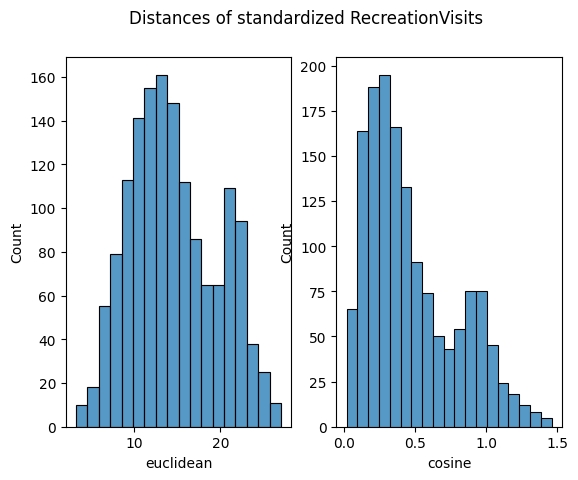

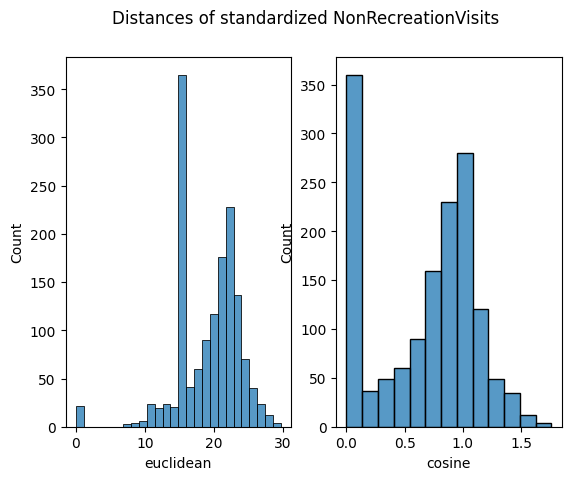

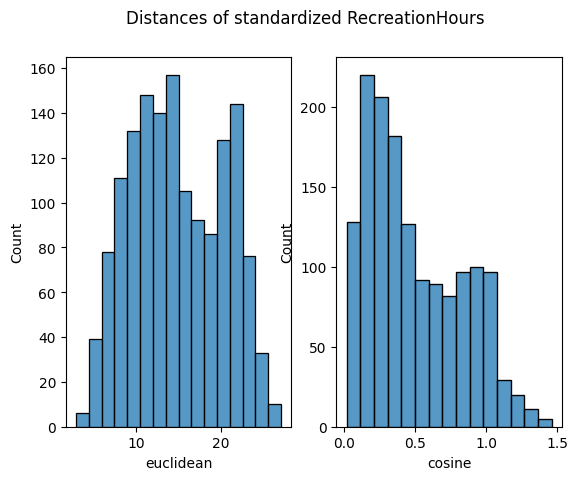

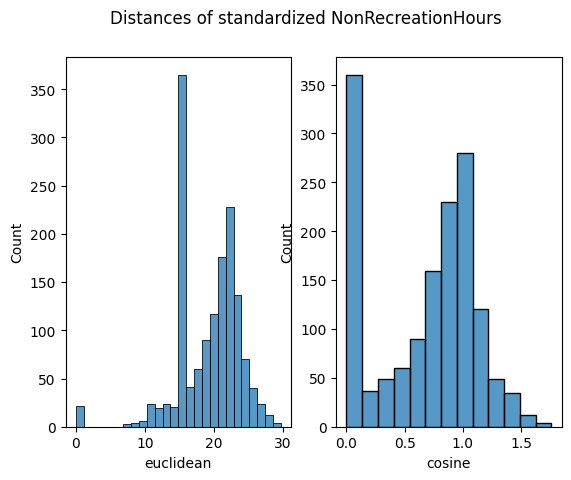

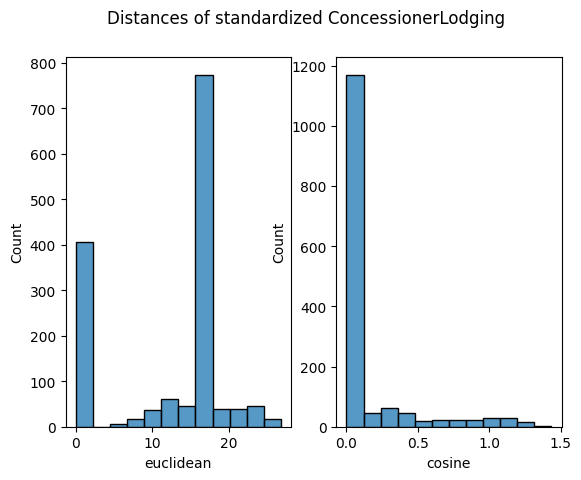

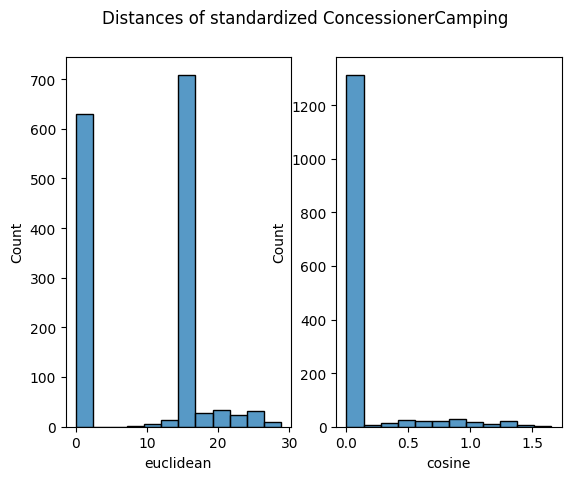

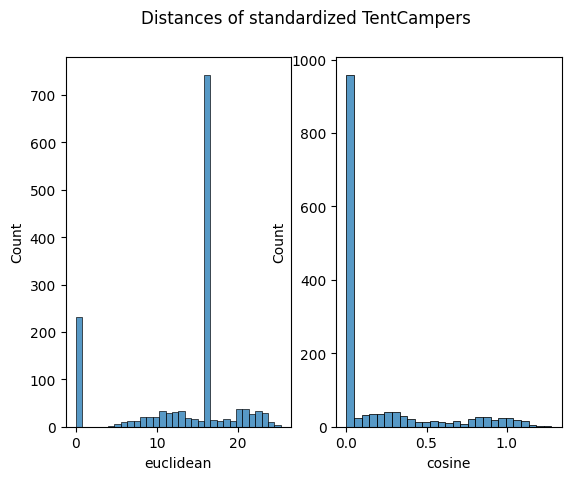

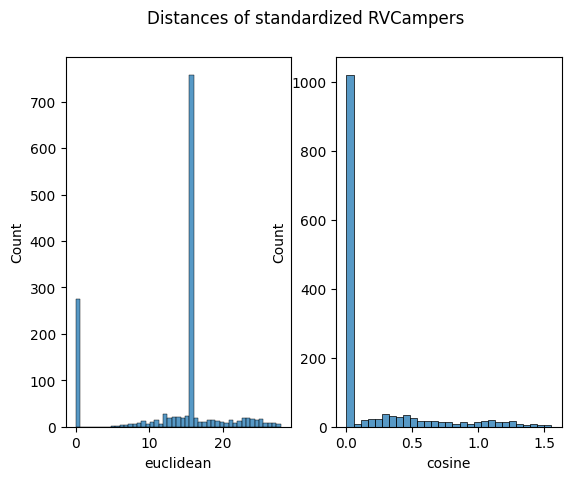

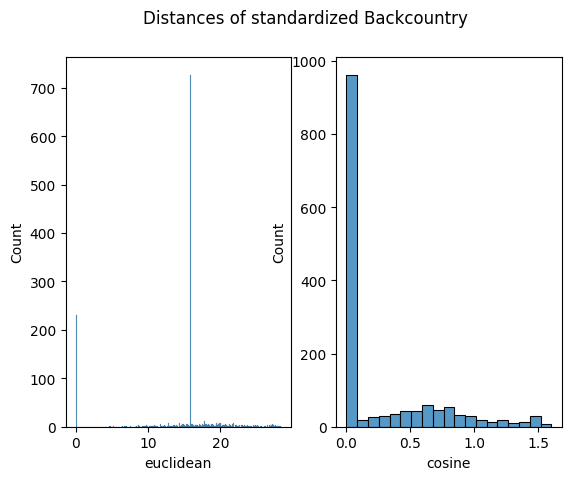

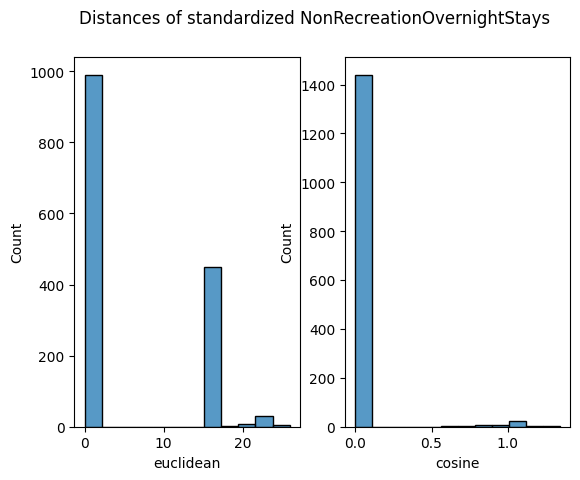

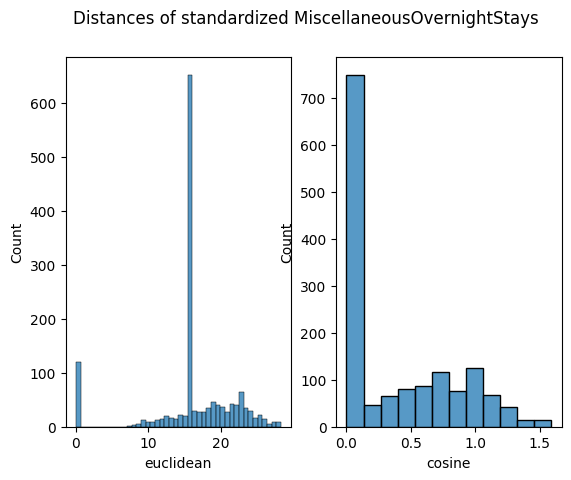

In [65]:
for x in similarities.keys():
    fig, ax =plt.subplots(1,2)
    sns.histplot(similarities[x]['euclidean'],ax=ax[0])
    sns.histplot(similarities[x]['cosine'],ax=ax[1])
    #_ = plt.title()
    fig.suptitle(f'Distances of standardized {x}')
    plt.show()

In [67]:
similarities['RecreationVisits'].describe()

,euclidean,cosine,abs_cosine
count,1485.000000,1485.000000,1485.000000
mean,14.580604,0.475312,0.475312
std,5.101985,0.315781,0.315781
min,3.182561,0.020177,0.020177
25%,10.679643,0.227201,0.227201
50%,13.857290,0.382519,0.382519
75%,18.525828,0.683678,0.683678
max,27.080477,1.460861,1.460861


The Euclidean distance of standardized RecreationVisits is bimodally distibuted: one center at 14 or so and one around 22. Now we want to do a seasonal trend analysis as well!

Text(0.513, 0.95, 'Michigan National Parks Recreational Visits')

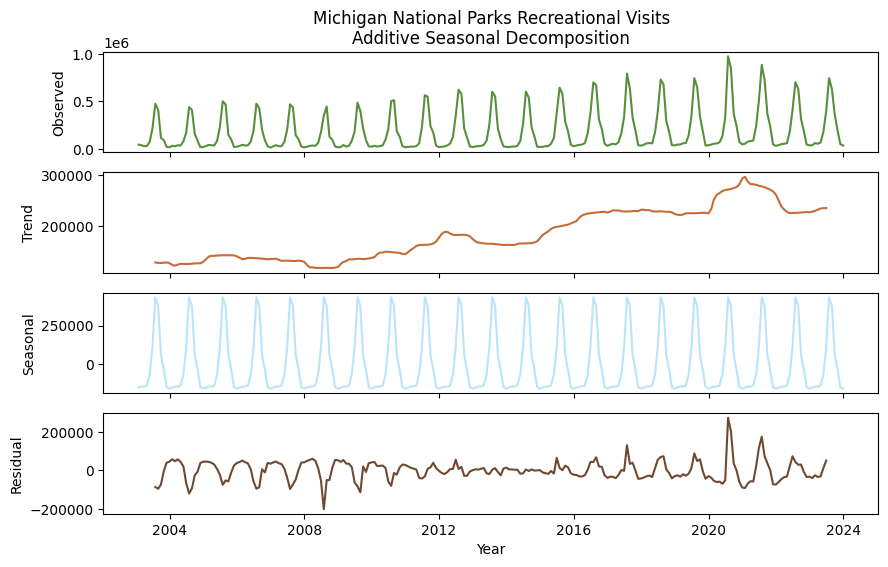

In [339]:
# MI rec visits as an example
state_agg_data=visit_data.groupby(['state_2','visit_type','date'])['number_of_visits'].sum().reset_index()
state_agg_data=state_agg_data[state_agg_data.visit_type=='RecreationVisits']
state_agg_data=state_agg_data.pivot(index='date',columns='state_2',values='number_of_visits')
state_agg_data.fillna(0,inplace=True)
state_agg_data.index = pd.to_datetime(state_agg_data.index, infer_datetime_format=True)
sea_decomp = seasonal_decompose(state_agg_data['MI'], model="additive",period=12) 
# 12 month period has the smoothest trend sign

# let's plot the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(sea_decomp.observed,color=palette[0]) # original/observed data
axes[0].set_ylabel("Observed")

axes[1].plot(sea_decomp.trend,color=palette[1]) # trend component
axes[1].set_ylabel("Trend")

axes[2].plot(sea_decomp.seasonal,color=palette[2])
axes[2].set_ylabel("Seasonal") # seasonality component 

axes[3].plot(sea_decomp.resid,color=palette[3]) #  time series with the trend and seasonal components removed
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Year")
fig.suptitle("Michigan National Parks Recreational Visits", x=0.513, y=0.95)

In [234]:
def get_data_for_decomp(df:pd.DataFrame,column:str='RecreationVisits')-> pd.DataFrame:
    '''Formats the seasonal data in a better format
    Input:
        df
        column: string, type of visit data e.g. RecreationVisits
    Output:
        df'''
    state_agg_data=df.groupby(['state_2','visit_type','date'])['number_of_visits'].sum().reset_index()
    state_agg_data=state_agg_data[state_agg_data.visit_type==column]
    state_agg_data=state_agg_data.pivot(index='date',columns='state_2',values='number_of_visits')
    state_agg_data.fillna(0,inplace=True)
    state_agg_data.index = pd.to_datetime(state_agg_data.index, infer_datetime_format=True)
    return state_agg_data

def sea_decomp(df:pd.DataFrame)->pd.DataFrame:
    '''Extracts the seasonal & trend components of each column of a df.
    Input:
        df (pd.DataFrame): a df with a date time index, values are daily new cases

    Output:
        pd.DataFrame: each column has the seasonal component of a column.
    '''
    result = None
    for x in df.columns:
        sea_decomp = seasonal_decompose(df[x], model="additive",period=12)
        temp = pd.DataFrame(sea_decomp.seasonal)
        temp2 = pd.DataFrame(sea_decomp.trend)
        name = f'{x} seasonal'
        temp.columns = [name]
        temp2.columns = [f'{x} trend']
        if result is None: # for the first column
            result = temp.join(temp2)
        else:
            result = result.join(temp)
            result = result.join(temp2)
    return result

In [237]:
# get seasonal & trend decompositions
sea_comp_insert_data = get_data_for_decomp(visit_data)
seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
seasonal_trend_dec.head()

,AK seasonal,AK trend,AL seasonal,AL trend,AR seasonal,AR trend,AS seasonal,AS trend,AZ seasonal,AZ trend,...,VT seasonal,VT trend,WA seasonal,WA trend,WI seasonal,WI trend,WV seasonal,WV trend,WY seasonal,WY trend
date,,,,,,,,,,,,,,,,,,,,,
2003-01-31,-188679.511458,NaN,-19938.136979,NaN,-147411.613368,NaN,-195.369965,NaN,-290991.107812,NaN,...,-1775.629514,NaN,-428509.364583,NaN,-58818.283854,NaN,-107793.012153,NaN,-600930.906250,NaN
2003-02-28,-188384.921875,NaN,-13410.582813,NaN,-131962.609201,NaN,-228.374132,NaN,-242749.655729,NaN,...,-1771.571181,NaN,-411890.877083,NaN,-55025.692188,NaN,-100862.587153,NaN,-600026.727083,NaN
2003-03-31,-185403.982292,NaN,1209.108854,NaN,-26404.896701,NaN,209.540451,NaN,81131.281771,NaN,...,-1961.212847,NaN,-340263.127083,NaN,-54622.994271,NaN,-67166.812153,NaN,-601036.018750,NaN
2003-04-30,-177602.307292,NaN,809.240104,NaN,-6640.967535,NaN,190.459201,NaN,69061.969271,NaN,...,-2036.848264,NaN,-288619.339583,NaN,-41075.896354,NaN,-28191.424653,NaN,-586680.037500,NaN
2003-05-31,74456.765625,NaN,15665.713021,NaN,94900.924132,NaN,-3.149132,NaN,86113.775521,NaN,...,-1141.333681,NaN,-20963.162500,NaN,991.036979,NaN,33447.369097,NaN,-39134.529167,NaN


In [272]:
# create dict of seasonal values and trend values
seasonal_dicts = {'seasonal':seasonal_trend_dec[[x for x in seasonal_trend_dec.columns if 'seasonal' in x]],
                  'trend':seasonal_trend_dec[[x for x in seasonal_trend_dec.columns if 'trend' in x]].dropna()} # drop na because 12 null values
# init output
dtw_sim = {}

for key in seasonal_dicts.keys():
    df = seasonal_dicts[key]
    out_dict = {}
    # standardize with (x - mean)/std
    for st in df.columns:
        df[st]=df[st].apply(lambda x: (x-df[st].mean())/df[st].std())
    for c in df.columns:
        for x in df.columns:
            if x==c:
                continue
            euc_dict = scipy.spatial.distance.euclidean(list(df[x]),list(df[c]))
            cos_dict = scipy.spatial.distance.cosine(list(df[x]),list(df[c]))
            dtw_dict = dtw.distance(list(df[x]),list(df[c]))
            out_dict[frozenset([c,x])]=[euc_dict,cos_dict,dtw_dict]
    output = pd.DataFrame.from_dict(out_dict,orient='index').reset_index()
    output.columns = ['states','euclidean','cosine','dtw']
    # print the top similarities
    euc_top_10 = output.sort_values('euclidean',ascending=True).head(10)
    output['abs_cosine'] = output['cosine'].apply(lambda x: abs(x))
    cos_top_10 = output.sort_values('abs_cosine',ascending=True).head(10)
    dtw_top_10 = output.sort_values('dtw',ascending=True).head(10)
    print(f'----------------------------- {key} -----------------------------')
    print('The state pairs with the lowest euclidean distances (meaning most similar) are: ')
    print(list(set(x) for x in euc_top_10['states']))
    print()
    print('The state pairs with the lowest absolute value of cosine distance (meaning most similar) are: ')
    print(list(set(x) for x in cos_top_10['states']))
    print()
    print('The state pairs with the lowest dtw cost (meaning most similar) are: ')
    print(list(set(x) for x in dtw_top_10['states']))
    print()
    dtw_sim[key]=output


----------------------------- seasonal -----------------------------
The state pairs with the lowest euclidean distances (meaning most similar) are: 
[{'WA seasonal', 'WI seasonal'}, {'WY seasonal', 'CO seasonal'}, {'CO seasonal', 'ND seasonal'}, {'MT seasonal', 'WI seasonal'}, {'MT seasonal', 'SD seasonal'}, {'WY seasonal', 'SD seasonal'}, {'NE seasonal', 'SD seasonal'}, {'MD seasonal', 'PA seasonal'}, {'RI seasonal', 'OH seasonal'}, {'OR seasonal', 'WI seasonal'}]

The state pairs with the lowest absolute value of cosine distance (meaning most similar) are: 
[{'WA seasonal', 'WI seasonal'}, {'WY seasonal', 'CO seasonal'}, {'CO seasonal', 'ND seasonal'}, {'MT seasonal', 'WI seasonal'}, {'MT seasonal', 'SD seasonal'}, {'WY seasonal', 'SD seasonal'}, {'NE seasonal', 'SD seasonal'}, {'MD seasonal', 'PA seasonal'}, {'RI seasonal', 'OH seasonal'}, {'OR seasonal', 'WI seasonal'}]

The state pairs with the lowest dtw cost (meaning most similar) are: 
[{'WA seasonal', 'WI seasonal'}, {'WY sea

In [356]:
list(dtw_sim['seasonal'].iloc[0].states)[0].split()[0]

'AL'

In [363]:
visit_data[visit_data.state_2=='KY'].reset_index().iloc[0].Region.strip()

'Southeast'

In [364]:
def same_region(x:frozenset):
    first_state = list(x)[0].split()[0]
    second_state = list(x)[1].split()[0]
    return visit_data[visit_data.state_2==first_state].reset_index().iloc[0].Region.strip()==visit_data[visit_data.state_2==second_state].reset_index().iloc[0].Region.strip()
    

dtw_sim['seasonal']['same_region']=dtw_sim['seasonal']['states'].apply(lambda x: same_region(x))

In [365]:
dtw_sim['seasonal'].groupby('same_region')[['euclidean','cosine','dtw','abs_cosine']].mean()

,states,euclidean,cosine,dtw,abs_cosine,same_region
0,"(AL seasonal, AK seasonal)",10.722679,0.229036,6.504461,0.229036,False
1,"(AR seasonal, AK seasonal)",8.510093,0.144266,6.398751,0.144266,False
2,"(AS seasonal, AK seasonal)",27.765269,1.535678,11.219525,1.535678,False
3,"(AZ seasonal, AK seasonal)",9.871291,0.194108,6.592419,0.194108,False
4,"(AK seasonal, CA seasonal)",6.220343,0.077077,5.608591,0.077077,False
...,...,...,...,...,...,...
1480,"(WA seasonal, WV seasonal)",7.251278,0.104743,4.956751,0.104743,False
1481,"(WY seasonal, WA seasonal)",3.546936,0.025061,3.537336,0.025061,False
1482,"(WI seasonal, WV seasonal)",7.233846,0.104240,5.086591,0.104240,False
1483,"(WY seasonal, WI seasonal)",3.243275,0.020954,3.240422,0.020954,False


# Network
For our network similarity analysis, I will between states based on similarities of the types of parks in each state.

In [275]:
def calc_pairwise_sim(df:pd.DataFrame,title:str,type:str,standardize:bool):
    out_dict = {}
    # standardize with (x - mean)/std
    if standardize:
        for st in df.columns:
            df[st]=df[st].apply(lambda x: (x-df[st].mean())/df[st].std())
    for c in df.columns:
        for x in df.columns:
            if x==c:
                continue
            euc_dict = scipy.spatial.distance.euclidean(list(df[x]),list(df[c]))
            cos_dict = scipy.spatial.distance.cosine(list(df[x]),list(df[c]))
            jac_dict = scipy.spatial.distance.jaccard(list(df[x]),list(df[c]))
            dtw_dict = dtw.distance(list(df[x]),list(df[c]))
            out_dict[frozenset([c,x])]=[euc_dict,cos_dict,dtw_dict,jac_dict]
    output = pd.DataFrame.from_dict(out_dict,orient='index').reset_index()
    output.columns = [title,'euclidean','cosine','dtw','jaccard']
    # print the top similarities
    euc_top_10 = output.sort_values('euclidean',ascending=True).head(10)
    output['abs_cosine'] = output['cosine'].apply(lambda x: abs(x))
    cos_top_10 = output.sort_values('abs_cosine',ascending=True).head(10)
    dtw_top_10 = output.sort_values('dtw',ascending=True).head(10)
    jacc_top_10 = output.sort_values('jaccard',ascending=False).head(10)
    print(f'----------------------------- {type} -----------------------------')
    print('The state pairs with the lowest euclidean distances (meaning most similar) are: ')
    print(list(set(x) for x in euc_top_10[title]))
    print()
    print('The state pairs with the lowest absolute value of cosine distance (meaning most similar) are: ')
    print(list(set(x) for x in cos_top_10[title]))
    print()
    print('The state pairs with the lowest dtw cost (meaning most similar) are: ')
    print(list(set(x) for x in dtw_top_10[title]))
    print()
    print('The state pairs with the highest jaccard sim (meaning most similar) are: ')
    print(list(set(x) for x in jacc_top_10[title]))
    return output

In [276]:
park_types = list(visit_data.ParkType.unique())
states = list(visit_data.state_2.unique())

state_vectors = {}
for st in states:
    size = []
    for park in park_types:
        size.append(visit_data[(visit_data.state_2==st) & (visit_data.ParkType==park)]['ParkName'].nunique())
    state_vectors[st]=size

output = pd.DataFrame.from_dict(state_vectors,orient='index')
output.columns = park_types
output =output.T

In [334]:
# check the head
output.head()

,KY,ME,MA,NY,NE,AK,TX,PA,GA,TN,...,IL,VT,NJ,MS,AS,RI,NH,PR,GU,CT
National Historical Park,2,0,5,2,1,2,3,2,3,0,...,1,1,3,1,0,0,1,0,1,1
National Park,1,1,0,0,0,8,2,0,0,1,...,0,0,0,0,1,0,0,0,0,0
National Monument,2,1,0,6,2,2,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
National Wild & Scenic River,0,0,0,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
National Historic Site,0,0,7,8,0,0,1,6,1,1,...,1,0,0,0,0,0,0,1,0,0


In [278]:
park_distribution =calc_pairwise_sim(output,'state','Park Distribution',False)
park_distribution.head()

----------------------------- Park Distribution -----------------------------
The state pairs with the lowest euclidean distances (meaning most similar) are: 
[{'GU', 'CT'}, {'VT', 'NH'}, {'VT', 'GU'}, {'VT', 'CT'}, {'DE', 'VT'}, {'DE', 'GU'}, {'DE', 'CT'}, {'NJ', 'LA'}, {'DE', 'NH'}, {'NH', 'CT'}]

The state pairs with the lowest absolute value of cosine distance (meaning most similar) are: 
[{'GU', 'CT'}, {'DE', 'CT'}, {'DE', 'GU'}, {'DE', 'NH'}, {'NJ', 'DE'}, {'DE', 'VT'}, {'CT', 'LA'}, {'GU', 'LA'}, {'NH', 'LA'}, {'NJ', 'LA'}]

The state pairs with the lowest dtw cost (meaning most similar) are: 
[{'GU', 'CT'}, {'VT', 'NH'}, {'IN', 'VI'}, {'VT', 'GU'}, {'VT', 'CT'}, {'DE', 'VT'}, {'IL', 'VI'}, {'DE', 'NH'}, {'DE', 'GU'}, {'MT', 'NV'}]

The state pairs with the highest jaccard sim (meaning most similar) are: 
[{'NM', 'GU'}, {'AR', 'GU'}, {'KY', 'MA'}, {'NM', 'CT'}, {'SD', 'CO'}, {'SD', 'FL'}, {'KS', 'SD'}, {'MN', 'AL'}, {'SD', 'LA'}, {'SD', 'SC'}]


,state,euclidean,cosine,dtw,jaccard,abs_cosine
0,"(KY, ME)",2.449490,0.422650,2.449490,0.750000,0.422650
1,"(KY, MA)",8.062258,0.617640,6.244998,1.000000,0.617640
2,"(KY, NY)",9.591663,0.502664,8.000000,0.857143,0.502664
3,"(KY, NE)",1.732051,0.183503,1.732051,0.750000,0.183503
4,"(KY, AK)",7.681146,0.411032,6.557439,0.600000,0.411032


In [283]:
park_distribution.describe()

,euclidean,cosine,dtw,jaccard,abs_cosine
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,5.118759,0.623682,4.024688,0.899955,0.623682
std,3.298338,0.274006,2.931588,0.147383,0.274006
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.645751,0.411652,2.000000,0.833333,0.411652
50%,3.872983,0.622036,3.000000,1.000000,0.622036
75%,6.782330,0.852156,5.291503,1.000000,0.852156
max,16.492423,1.000000,12.489996,1.000000,1.000000


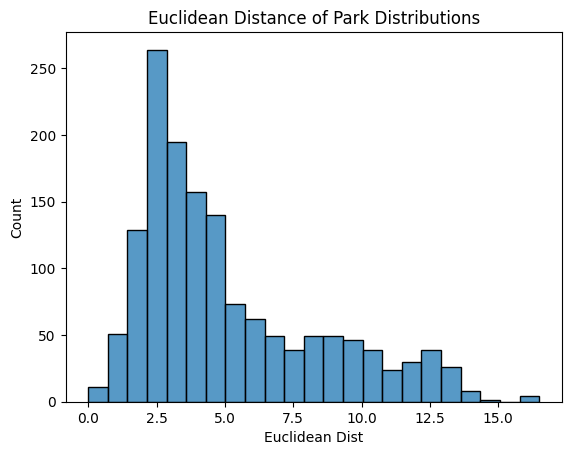

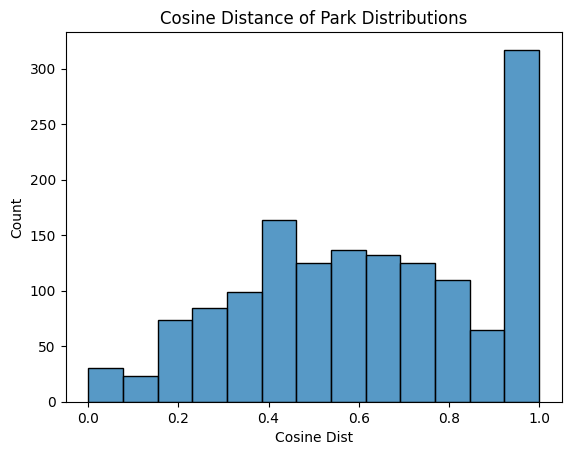

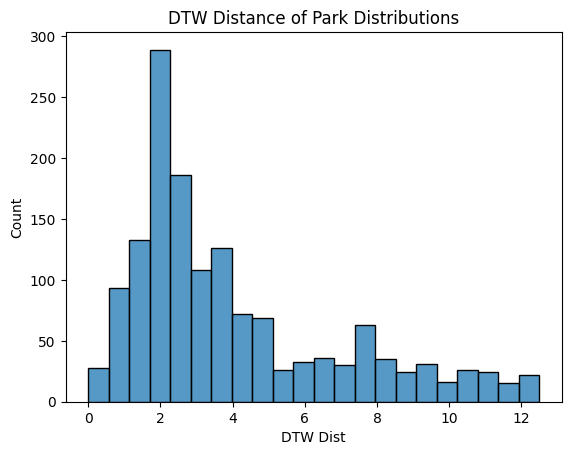

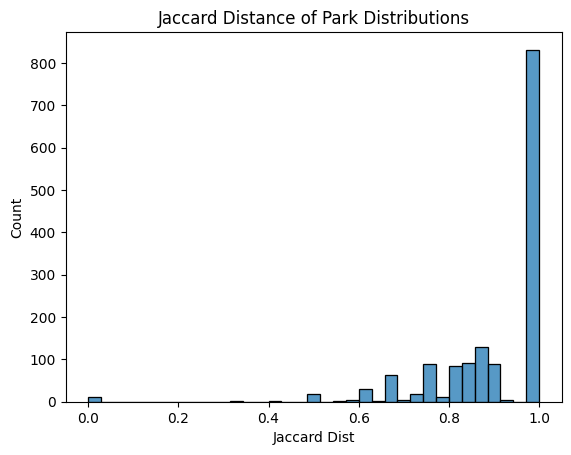

In [299]:
sns.histplot(park_distribution,x='euclidean')
plt.xlabel('Euclidean Dist')
_ = plt.title('Euclidean Distance of Park Distributions')
plt.show()
sns.histplot(park_distribution,x='cosine')
plt.xlabel('Cosine Dist')
_ = plt.title('Cosine Distance of Park Distributions')
plt.show()
sns.histplot(park_distribution,x='dtw')
plt.xlabel('DTW Dist')
_ = plt.title('DTW Distance of Park Distributions')
plt.show()
sns.histplot(park_distribution,x='jaccard')
plt.xlabel('Jaccard Dist')
_ = plt.title('Jaccard Distance of Park Distributions')
plt.show()

In [310]:
rec_node_list = park_distribution.copy()
rec_node_list['state1']=rec_node_list['state'].apply(lambda x: list(x)[0])
rec_node_list['state2']=rec_node_list['state'].apply(lambda x: list(x)[1])
rec_node_list=rec_node_list[rec_node_list.euclidean < 2.645751]

In [311]:
# read the graph in
G = nx.from_pandas_edgelist(rec_node_list,'state1','state2','euclidean')

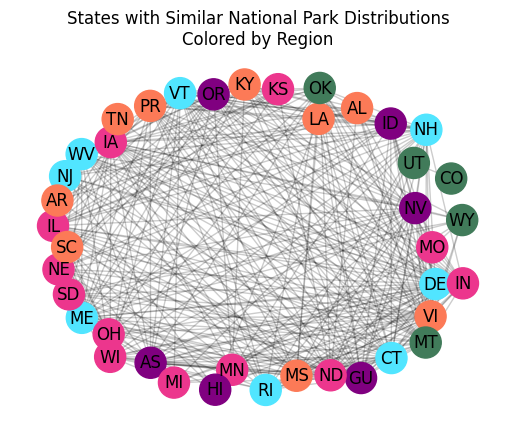

In [331]:
# map state to region, for coloring purposes
state_to_region = visit_data.set_index('state_2')[['Region']].T.to_dict()
# create color map
colors = {'Alaska':'#1F2041',
 'Intermountain ':'#417B5A',
 'Midwest ':'#EC368D',
 'National Capital ':'#50FFB1',
 'Northeast ':'#51E5FF',
 'Pacific West ':'purple',
 'Southeast ':'#FC7A57'}
# get nodes & assign colors
nodes = G.nodes()
colors = [colors[state_to_region[n]["Region"]] for n in nodes]
# draw
#pos = nx.random_layout(G,seed=78)
pos = nx.spring_layout(G,k=35/np.sqrt(G.number_of_nodes()))
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, node_size=500)
lb = nx.draw_networkx_labels(G,pos)
plt.title('States with Similar National Park Distributions\nColored by Region')
plt.axis('off')
plt.show()

In [313]:
# create dataframe with node info
node_info = pd.DataFrame.from_dict(dict(nx.degree(G)),orient='index').reset_index()
node_info.columns=['state','degree']
# add page rank
pr = nx.pagerank(G)
node_info['pagerank']=node_info['state'].apply(lambda x: pr[x])
# add clustering
clust = nx.clustering(G)
node_info['clust']=node_info['state'].apply(lambda x: clust[x])

In [314]:
# top degree
print('top degree')
print(node_info.sort_values('degree',ascending=False).head(5)[['state','degree']])
print('Top Pagerank')
print(node_info.sort_values('pagerank',ascending=False).head(5)[['state','pagerank']])
print('Top Clust')
print(node_info.sort_values('clust',ascending=False).head(5)[['state','clust']])

top degree
   state  degree
3     VI      30
25    IL      28
9     IN      27
23    IA      27
11    NV      26
Top Pagerank
   state  pagerank
3     VI  0.040353
25    IL  0.038126
19    MT  0.036531
9     IN  0.036510
23    IA  0.035867
Top Clust
   state     clust
35    AR  1.000000
31    MI  1.000000
28    RI  0.970760
21    OK  0.905263
17    WI  0.900585


The states with the highest degrees are the Virgin Islands, Illinois, and Indiana. The states with the highest pagerank values are the Virgin Islands, Illinois, and Montana while the states with the highest clustering levels are Arkansas, Michigan, and Rhode Island.

The states with the lowest degrees are Tennessee, Utah, and Colorado. Tennessee, Arkansas, and Hawaii have the lowest page rank values. The states with the smallest clustering values are Colorado, Utah, Tennessee, and Hawaii.
It stands out that Tennessee is in all three of these lists. It appears that this state is an outlier.

In [315]:
# top degree
print('Lowest degree')
print(node_info[node_info.degree==1][['state','degree']])
print('Lowest Pagerank')
print(node_info.sort_values('pagerank',ascending=True).head(5)[['state','pagerank']])
print('Lowest Clust')
print(node_info.sort_values('clust',ascending=True).head(5)[['state','clust']])

Lowest degree
   state  degree
30    TN       1
32    UT       1
33    CO       1
Lowest Pagerank
   state  pagerank
30    TN  0.004992
35    AR  0.008173
39    HI  0.010843
38    SC  0.012403
31    MI  0.012772
Lowest Clust
   state     clust
33    CO  0.000000
32    UT  0.000000
30    TN  0.000000
39    HI  0.500000
5     OH  0.527778


In [329]:
G.number_of_nodes(),G.number_of_edges()

(40, 336)

In [330]:
comp = nx.connected_components(G)
subgraphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print('There are ',len([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]),' connected components.')
for g in subgraphs:
    print('---For subgraph of length ',g.number_of_nodes(),' nodes and ',g.number_of_edges(),' edges.')
    sp = nx.average_shortest_path_length(g)
    print('The average shortest path length is ',sp,'.')
    cluster = nx.average_clustering(g)
    print('The average clustering is ',cluster,'.')
    print('Nodes: ',g.nodes())

There are  2  connected components.
---For subgraph of length  38  nodes and  335  edges.
The average shortest path length is  1.5803698435277382 .
The average clustering is  0.7393698065490253 .
Nodes:  ['KY', 'ME', 'NE', 'VI', 'LA', 'OH', 'ID', 'OR', 'DE', 'IN', 'MN', 'NV', 'VT', 'NJ', 'NH', 'GU', 'CT', 'WI', 'SD', 'MT', 'WV', 'OK', 'WY', 'IA', 'ND', 'IL', 'MS', 'AS', 'RI', 'PR', 'TN', 'MI', 'KS', 'AR', 'AL', 'MO', 'SC', 'HI']
---For subgraph of length  2  nodes and  1  edges.
The average shortest path length is  1.0 .
The average clustering is  0.0 .
Nodes:  ['UT', 'CO']


In [332]:
node_info['region']=node_info.state.apply(lambda n: state_to_region[n]["Region"])
region_values =node_info.groupby('region')[['pagerank','degree','clust']].mean()
region_values

,pagerank,degree,clust
region,,,
Intermountain,0.025626,11.200000,0.490830
Midwest,0.023852,16.416667,0.739979
Northeast,0.030223,22.625000,0.793526
Pacific West,0.027283,19.833333,0.710120
Southeast,0.020019,13.222222,0.683691


In [335]:
region_values.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n & pagerank & degree & clust \\\\\nregion &  &  &  \\\\\n\\midrule\nIntermountain  & 0.025626 & 11.200000 & 0.490830 \\\\\nMidwest  & 0.023852 & 16.416667 & 0.739979 \\\\\nNortheast  & 0.030223 & 22.625000 & 0.793526 \\\\\nPacific West  & 0.027283 & 19.833333 & 0.710120 \\\\\nSoutheast  & 0.020019 & 13.222222 & 0.683691 \\\\\n\\bottomrule\n\\end{tabular}\n'

The Southeast the lowest page rank scores, meaning these states are the least influential. The Pacific West & Northeast have the highest page rank scores meaning their states are the most influential (and most similar). They also have the highest degree. Alaska and the National Capitol are not even included in the graph, meaning they contain the least similar states to all states. This makes sense, given that Alaska is geographically isolated and the National Capitol has a unique amount of National Monuments and Military parks. The Northeast has the highest clustering value, meaning that the highest ratio of closed triangles that run through the Northeast states. This means that most of the states in the Northeast's neighbors are also connected to those state's other neighbors.

MORE IDEAS
* Could try ACF plot